## ======= Libraries =======

In [1]:
# Determinadas
import numpy as np
import pandas
import matplotlib.pyplot as plt

# Procesamiento de imágenes
import cv2

# <br><br><br><br><br>======= Part 1 =======

### Given 2 input gray-scale images, create a binary image mask and blend the images in a seamless way. The gray-scale resulting image should show a smooth transition between the two images(from side to side).

### -SmootTransition Class

$$Combined Laplacian_k = (Mask_k * LaplacianA_k) + ((1-Mask_k) * LaplacianB_k)$$

In [2]:
class SmoothTransition:
    def __init__(self, imgA, imgB, mask, levels=1):
        self.imgA = imgA # Imagen A.
        self.imgB = imgB # Imagen B.
        self.mask = mask # Máscara de la combinación.
        self.levels = levels # Niveles a usar en la pirámide Gaussiana.
        self.mask_pyramid = [] # Pirámide Gaussiana de la máscara.
        self.gaussian_pyramid_A = [] # Pirámide Gaussiana de la imagen A.
        self.gaussian_pyramid_B = [] # Pirámide Gaussiana de la imagen B.
        self.laplacian_pyramid_A = [] # Pirámide Laplaciana de la imagen A.
        self.laplacian_pyramid_B = [] # Pirámide Laplaciana de la imagen B.
        self.reconstructed_laplacian = [] # Pirámide de imágenes donde ya están combinadas.
        self.solution = None # Solución Laplaciana.
        
    def getGaussianPyramid(self, img):
        ''' Regresa la pirámide Gaussiana de una imagen dada.
            img = Imagen. '''
        
        # Pirámides Gaussianas.
        gaussian_pyramid = [img]

        # Crear pirámide Gaussiana.
        img_copy = img.copy()

        for i in range(self.levels):
            # Bajar pirámide (comprimir).
            img_copy = cv2.pyrDown(img_copy)

            # Añadir a la lista.
            gaussian_pyramid.append( np.float32(img_copy) )

        return gaussian_pyramid
    
    def getLaplacianPyramid(self, gaussian_pyramid):
        ''' Regresa la pirámide Laplaciana dada una pirámide Gaussiana.
            gaussian_pyramid = Pirámide Gaussiana de una imagen dada. '''
        
        # Pirámides Laplacianas.    
        laplacian_pyramid = [gaussian_pyramid[-1]]

        for i in range(self.levels,0,-1):
            # Obtener tamaños de las imágenes de la pirámige Gaussiana.
            size = (gaussian_pyramid[i-1].shape[1], gaussian_pyramid[i-1].shape[0])

            # Subir pirámide (expandir).
            up_img = cv2.pyrUp(gaussian_pyramid[i], dstsize=size)

            # Imagen Laplace.
            laplacian_img = gaussian_pyramid[i-1] - up_img

            # Añadir a la lista.
            laplacian_pyramid.append(laplacian_img)

        return laplacian_pyramid
    
    def mergeImages(self):
        ''' Regresa una lista de imágenes donde se hizo la unión entre la imagen A y la imagen B (cada imagen de
            la lista tiene dimensiones diferentes; sigue el formato de una pirámide: 100x100 -> 50x50 -> 25x25)'''
        
        # Lista de imágenes Laplacianas combinadas.
        combined_laplacian = []

        # Combinar imágenes.
        for i in range(len(self.laplacian_pyramid_A)):
            # (Combined Laplacian)_k = (Mask_k * LaplacianA_k) + ((1-Mask_k) * LaplacianB_k)
            res = (self.mask_pyramid[i] * self.laplacian_pyramid_A[i]) + ((1-self.mask_pyramid[i]) * self.laplacian_pyramid_B[i])

            # Añadir a la lista.
            combined_laplacian.append(res)

        # Variables a utilizar.
        laplacian_solution = combined_laplacian[0]
        reconstructed_laplacian = [laplacian_solution]
        
        # Reconstrucción de la imagen.
        for i in range(len(combined_laplacian)-1):
            # Obtener tamaños de las imágenes de la pirámige Gaussiana.
            size = (combined_laplacian[i+1].shape[1], combined_laplacian[i+1].shape[0])

            # Subir pirámide (expandir).
            up_img = cv2.pyrUp(laplacian_solution, dstsize=size)

            # Suma.
            laplacian_solution = combined_laplacian[i+1] + up_img

            # Añadir a la lista.
            reconstructed_laplacian.append(laplacian_solution)
            
        return reconstructed_laplacian
    
    def solve(self):
        ''' No retorna nada.
            Pone la imagen que es la solución final en self.solution. '''
        
        # Máscara.
        self.mask_pyramid = self.getGaussianPyramid(self.mask) # Obtener pirámide Gaussiana de la máscara.
        self.mask_pyramid.reverse() # Invertir lista.

        # Pirámides Gaussianas de las imágenes.
        self.gaussian_pyramid_A = self.getGaussianPyramid(self.imgA)
        self.gaussian_pyramid_B = self.getGaussianPyramid(self.imgB)

        # Pirámides Laplacianas de las imágenes.
        self.laplacian_pyramid_A = self.getLaplacianPyramid(self.gaussian_pyramid_A)
        self.laplacian_pyramid_B = self.getLaplacianPyramid(self.gaussian_pyramid_B)
        
        # Unir imágenes.
        self.reconstructed_laplacian = self.mergeImages()
        
        # Solución.
        self.solution = np.uint8(self.reconstructed_laplacian[-1])

### Load Data

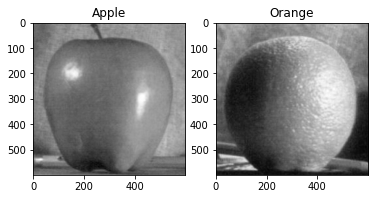

In [3]:
# Cargar imágenes.
imgA = cv2.imread(r'Datasets/Apple.png')
imgB = cv2.imread(r'Datasets/Orange.png')

# RGB.
imgA = cv2.cvtColor(imgA, cv2.COLOR_BGR2RGB)
imgB = cv2.cvtColor(imgB, cv2.COLOR_BGR2RGB)

# Grayscale.
imgA_gray = cv2.cvtColor(imgA, cv2.COLOR_RGB2GRAY)
imgB_gray = cv2.cvtColor(imgB, cv2.COLOR_RGB2GRAY)

# Obtener forma de la imagen.
height, width, channels = imgA.shape

# Mostrar imagen.
plt.figure()
plt.subplot(1,2,1)
plt.imshow(imgA_gray, cmap="gray")
plt.title("Apple")
plt.subplot(1,2,2)
plt.imshow(imgB_gray, cmap="gray")
plt.title("Orange")
plt.show()

### Solution (Grayscale)

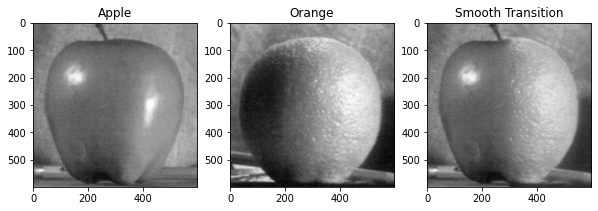

In [4]:
# Número de niveles en la pirámide Gaussiana (más niveles = más difuminación, hasta un cierto límite ya deja de mejorar)
levels = 6

# Forma de la máscara.
mask = np.zeros_like(imgA_gray, dtype='float32')
mask[:,:imgA_gray.shape[1]//2] = 1

# Resolver.
solution1 = SmoothTransition(imgA_gray, imgB_gray, mask, levels=levels)
solution1.solve()


# Mostrar imagen.
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(imgA_gray, cmap="gray")
plt.title("Apple")
plt.subplot(1,3,2)
plt.imshow(imgB_gray, cmap="gray")
plt.title("Orange")
plt.subplot(1,3,3)
plt.imshow(solution1.solution, cmap="gray")
plt.title("Smooth Transition")
plt.show()

### Solution (Color)

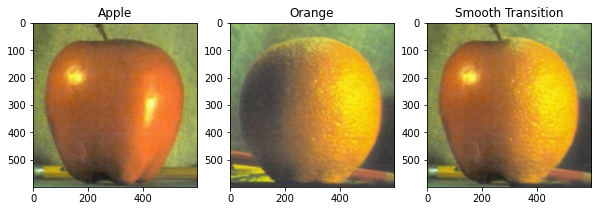

In [5]:
# Forma de la máscara.
mask = np.zeros_like(imgA, dtype='float32')
mask[:,:imgA.shape[1]//2] = 1

# Resolver.
solution2 = SmoothTransition(imgA, imgB, mask, levels=levels)
solution2.solve()


# Mostrar imagen.
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(imgA)
plt.title("Apple")
plt.subplot(1,3,2)
plt.imshow(imgB)
plt.title("Orange")
plt.subplot(1,3,3)
plt.imshow(solution2.solution)
plt.title("Smooth Transition")
plt.show()

# <br><br><br><br><br>======= Part 2 =======

### Create a gray-scale image mask.

### Blend the images in a seamless way. The color resulting image should show a smooth transition between the two images).

### Load Data

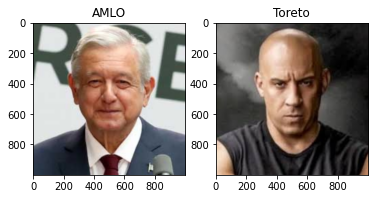

In [6]:
# Cargar imágenes.
imgA_part2 = cv2.imread(r'Datasets/AMLO.jpg')
imgA_part2 = cv2.resize(imgA_part2, (1000, 1000))
imgB_part2 = cv2.imread(r'Datasets/Toreto.jpg')
imgB_part2 = cv2.resize(imgB_part2, (1000, 1000))

# RGB.
imgA_part2 = cv2.cvtColor(imgA_part2, cv2.COLOR_BGR2RGB)
imgB_part2 = cv2.cvtColor(imgB_part2, cv2.COLOR_BGR2RGB)

# Obtener forma de la imagen.
height, width, channels = imgA_part2.shape

# Mostrar imagen.
plt.figure()
plt.subplot(1,2,1)
plt.imshow(imgA_part2)
plt.title("AMLO")
plt.subplot(1,2,2)
plt.imshow(imgB_part2)
plt.title("Toreto")
plt.show()

### Load Mask

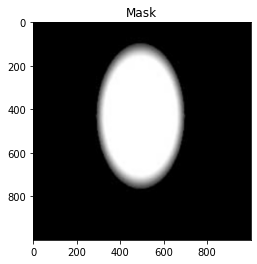

In [7]:
# Número de niveles en la pirámide Gaussiana (más niveles = más difuminación, hasta un cierto límite ya deja de mejorar)
levels = 5

# Cargar máscara..
mask_part2 = cv2.imread(r'Datasets/Mask_gradient.jpg')
mask_part2 = cv2.resize(mask_part2, (1000, 1000))

# Cambiar tipo de dato.
mask_part2 = np.float32(mask_part2)

# Rango de 0 a 1.
mask_part2 /= 255

# Mostrar imagen.
plt.figure()
plt.imshow(mask_part2, cmap='gray')
plt.title('Mask')
plt.show()

### Solution

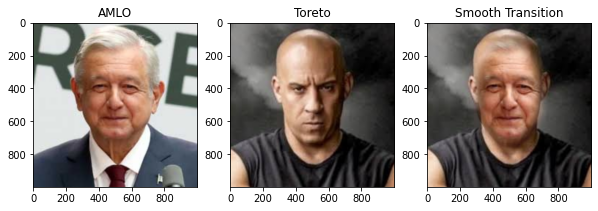

In [8]:
# Resolver.
solution_part2 = SmoothTransition(imgA_part2, imgB_part2, mask_part2, levels=levels)
solution_part2.solve()

# Mostrar imagen.
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(imgA_part2)
plt.title("AMLO")
plt.subplot(1,3,2)
plt.imshow(imgB_part2)
plt.title("Toreto")
plt.subplot(1,3,3)
plt.imshow(solution_part2.solution)
plt.title("Smooth Transition")
plt.show()